In [2]:
from IPython.display import clear_output

%cd /content 
!rm -rf yolov5
#!git clone https://github.com/ultralytics/yolov5  # clone repo
!git clone https://github.com/tiendzung-le/yolov5
%cd /content/yolov5
# %pip install -qr requirements.txt pycocotools # install dependencies
%pip install -qr requirements.txt # install dependencies

import torch

%cd /content 
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import random
import math
import shutil
from tqdm import tqdm
tqdm.pandas()

from glob import glob

from PIL import Image
import skimage.io

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import os.path  
import torch

seed = 2021
def set_seeds(seed):
  np.random.seed(seed)
  random.seed(seed)

  torch.manual_seed(seed)
  torch.use_deterministic_algorithms(True)

set_seeds(seed)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Data

In [4]:
urls = """https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/sentinel-2-part1.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/extra_train-planet-dec17.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/extra_train-planet-jun18.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/starter-notebook.ipynb
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/extra_train-sentinel.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/sentinel_for_points_collected_in_2015.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/extra_train-planet-jun17.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/extra_train-planet-dec18.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/train-unique.csv
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/sample_submission.csv
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/extra_train.csv
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/auxilary_data-unique.csv
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/planet-jun18.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/planet-dec17.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/planet-dec18.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/planet-jun17.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/sentinel-2-part2.zip
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/ImageBands.docx
https://api.zindi.africa/v1/competitions/lacuna-correct-field-detection-challenge/files/test.csv"""

urls = urls.split()
urls = [u for u in urls if "sentinel" not in u]

if not os.path.isfile("/content/lacuna-data/planet-jun17.zip"):
  print("Downloading data ...")
  import requests
  import requests, zipfile
  !rm * -rf
  for url in urls:
      myobj = {'auth_token': 'YOUR_TOKEN'} 
      x = requests.post(url, data = myobj,stream=True)
      target_path = url.split('/')[-1]
      handle = open(target_path, "wb")
      for chunk in x.iter_content(chunk_size=512):
          if chunk:  # filter out keep-alive new chunks
              handle.write(chunk)
      handle.close()

  for u in urls:
    filename = u.split("/")[-1]
    if "zip" in filename:
      !unzip -qq $filename
      
  !mkdir -p input
  !mv *.csv input
  !mv *.zip input
  !mv *.docx input
  !mv *17 input
  !mv *18 input
  !mv input lacuna-data

else:
  print("Data are already ready.")

!ls -alh lacuna-data
# !unzip -qq /content/data.zip

total 207M
drwxr-xr-x 10 root root 4.0K Jun 24 11:43 .
drwxr-xr-x  1 root root 4.0K Jun 24 11:43 ..
-rw-r--r--  1 root root  46K Jun 24 11:43 auxilary_data-unique.csv
-rw-r--r--  1 root root  64K Jun 24 11:43 extra_train.csv
drwxr-xr-x  2 root root  36K Jun 24 11:43 extra_train-planet-dec17
-rw-r--r--  1 root root  12M Jun 24 11:42 extra_train-planet-dec17.zip
drwxr-xr-x  2 root root  36K Jun 24 11:43 extra_train-planet-dec18
-rw-r--r--  1 root root  11M Jun 24 11:42 extra_train-planet-dec18.zip
drwxr-xr-x  2 root root  36K Jun 24 11:43 extra_train-planet-jun17
-rw-r--r--  1 root root  12M Jun 24 11:42 extra_train-planet-jun17.zip
drwxr-xr-x  2 root root  36K Jun 24 11:43 extra_train-planet-jun18
-rw-r--r--  1 root root  11M Jun 24 11:42 extra_train-planet-jun18.zip
-rw-r--r--  1 root root 483K Jun 24 11:43 ImageBands.docx
drwxrwxr-x  2 root root 108K Apr  1 15:37 planet-dec17
-rw-r--r--  1 root root  43M Jun 24 11:43 planet-dec17.zip
drwxrwxr-x  2 root root 112K Apr  1 15:37 planet-de

# Yolo Labels

In [5]:
def get_radius(a, ratio=10):
    am = a * 4046.86
    r = math.sqrt(am / math.pi)
    return round(r * ratio/ 1000, 3) # km

def get_delta(r):
    x = r["x"]
    y = r["y"]
    return math.sqrt(x*x + y*y)

data_dir = "."

df_extra = pd.read_csv(f"{data_dir}/lacuna-data/extra_train.csv")
df_extra["extra"] = 1
df_train = pd.read_csv(f"{data_dir}/lacuna-data/train-unique.csv")
df_train["extra"] = 0
df = pd.concat([df_train, df_extra]).reset_index(drop=True)

df["r"] = df["PlotSize_acres"].map(get_radius)
df["delta"] = df.apply(lambda r: get_delta(r), axis=1)
df["ratio"] = df["delta"] / df["r"]
df["is_center"] = (df["delta"] < 0.005).astype(int)
df.tail()

,ID,Year,PlotSize_acres,Yield,Quality,x,y,extra,r,delta,ratio,is_center
1360,id_a00f87f1,2018,1.25,NaN,1,0.485319,-0.186216,1,0.401,0.519818,1.296304,0
1361,id_34c03f1b,2018,1.00,NaN,1,-0.203676,0.626730,1,0.359,0.658995,1.835640,0
1362,id_527c7ba7,2018,0.50,NaN,2,-0.267280,0.432704,1,0.254,0.508598,2.002354,0
1363,id_bbf9789c,2017,0.50,0.31125,1,-0.582584,-0.750224,1,0.254,0.949863,3.739618,0
1364,id_87f728dd,2018,0.25,NaN,2,0.170059,0.340570,1,0.179,0.380668,2.126637,0


In [6]:
df["Quality"].value_counts()

1    650
2    359
3    356
Name: Quality, dtype: int64

0.34842986778381924
0    1207
1     158
Name: is_center, dtype: int64


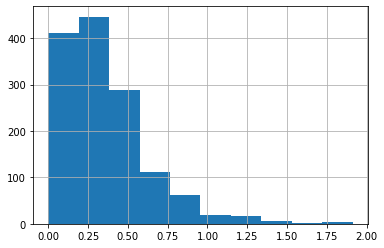

In [7]:
print(df["delta"].mean())
print(df["is_center"].value_counts())
df["delta"].hist()

In [8]:
CONST_X = 10.986328125 / 2
CONST_Y = 10.985731758 / 2

def load_RGB_images(ID, load_extra=False, data_dir = "./lacuna-data"):
  # e.g id_0b242e06 -> 0b242e06
  if load_extra:
    extra = 'extra_train-'
  else:
    extra = ''
  name = ID.split('_')[1]
  img_jun17 = skimage.io.imread(f'{data_dir}/{extra}planet-jun17/{name}.png')
  img_dec17 = skimage.io.imread(f'{data_dir}/{extra}planet-dec17/{name}.png')
  img_jun18 = skimage.io.imread(f'{data_dir}/{extra}planet-jun18/{name}.png')
  img_dec18 = skimage.io.imread(f'{data_dir}/{extra}planet-dec18/{name}.png')
  return img_jun17, img_dec17, img_jun18, img_dec18

def get_win_info(row):
    r = row["r"] # see other notebooks want the win to be shifted
    wx, wy = round(4 * r, 7), round(4 * r, 7)
        
    return (wx, wy)

def create_yolo_images_labels(row, output_dir="lacuna_images"):
    ID = row["ID"] # row.ID.values[0]
    extra = row["extra"] # row.extra.values[0] == 1
    img_jun17, img_dec17, img_jun18, img_dec18 = load_RGB_images(ID, extra)


    x0, y0 = img_jun18.shape[1]//2, img_jun17.shape[0]//2
    x1 = x0 - np.round(row["x"] / CONST_X * img_jun18.shape[1])
    y1 = y0 + np.round(row["y"] / CONST_Y * img_jun18.shape[0])
    r = np.round(row["r"] / CONST_X * img_jun17.shape[1])

    cx, cy = 0, 0
    (wx, wy) = row["win"]
    left,right = (cx-wx), (cx+wx)
    top,down = (cy-wy), (cy+wy)
    left = x0 - np.round(left / CONST_X * img_jun18.shape[1])
    right = x0 - np.round(right / CONST_X * img_jun18.shape[1])
    top = y0 + np.round(top / CONST_Y * img_jun18.shape[0])
    down = y0 + np.round(down / CONST_Y * img_jun18.shape[0])


    new_width = abs(int(right)-int(left))
    new_height = abs(int(top) - int(down))
    new_left = int(right) # inverted
    new_right = int(left)

    ccwh = [round((x1-new_left)/new_width, 3), round((y1-top)/new_height, 3), \
            round(2*r/new_width, 3), round(2*r/new_height, 3)]

    for img_full, period in zip([img_jun17, img_dec17, img_jun18, img_dec18], 
                                ["jun17", "dec17", "jun18", "dec18"]):
        im = img_full[int(top):int(down),new_left:new_right,:]
        im_fn = f"{output_dir}/{ID}_{period}.png"
        skimage.io.imsave(im_fn, im)
        
    return ccwh

MIN_R = 0.175 # 0.175
MAX_RATIO = 3.5
#MIN_QUALITY = 0

output_dir = "lacuna_images"
!mkdir -p $output_dir

#selected_rows = (df["r"] >= MIN_R) & (df["ratio"] <= MAX_RATIO) & (df["Quality"] >= MIN_QUALITY)
selected_rows = (df["r"] >= MIN_R) & (df["ratio"] <= MAX_RATIO)
df_yolo = df[selected_rows].copy().reset_index(drop=True)
print(df_yolo.shape, df.shape)

df_yolo["win"] = df_yolo.apply(lambda r: get_win_info(r), axis=1)
df_yolo.head()

df_yolo["yolo"] = df_yolo.progress_apply(lambda r: create_yolo_images_labels(r), axis=1)
df_yolo.to_csv("lacuna_yolo_5folds.csv", index=None)

clear_output()
df_yolo.head()

,ID,Year,PlotSize_acres,Yield,Quality,x,y,extra,r,delta,ratio,is_center,win,yolo
0,id_ade6610c,2018,0.25,NaN,2,-0.100546,0.131002,0,0.179,0.165139,0.922566,0,"(0.716, 0.716)","[0.591, 0.591, 0.273, 0.273]"
1,id_c987f14e,2018,2.00,NaN,1,-0.985732,-0.032197,0,0.508,0.986257,1.941452,0,"(2.032, 2.032)","[0.742, 0.5, 0.258, 0.258]"
2,id_a1ce519e,2017,1.50,0.26875,3,0.000000,0.000000,0,0.440,0.000000,0.000000,1,"(1.76, 1.76)","[0.5, 0.5, 0.259, 0.259]"
3,id_fe53ff60,2018,0.25,NaN,1,0.173911,0.273041,0,0.179,0.323723,1.808507,0,"(0.716, 0.716)","[0.364, 0.682, 0.273, 0.273]"
4,id_b6963bf4,2018,0.25,NaN,1,-0.154585,0.264809,0,0.179,0.306627,1.713000,0,"(0.716, 0.716)","[0.591, 0.682, 0.273, 0.273]"


# Train

In [9]:
from IPython.display import clear_output

%cd /content 
!rm -rf yolov5
#!git clone https://github.com/ultralytics/yolov5  # clone repo
!git clone https://github.com/tiendzung-le/yolov5
%cd /content/yolov5
# %pip install -qr requirements.txt pycocotools # install dependencies
%pip install -qr requirements.txt # install dependencies

import torch

%cd /content 
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='data/images/', update=False, view_img=False, weights=['yolov5s.pt'])
YOLOv5 🚀 v5.0-10-g585dd23 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

100% 14.1M/14.1M [00:00<00:00, 116MB/s]

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7266973 parameters, 0 gradients, 17.0 GFLOPS
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 1 fire hy

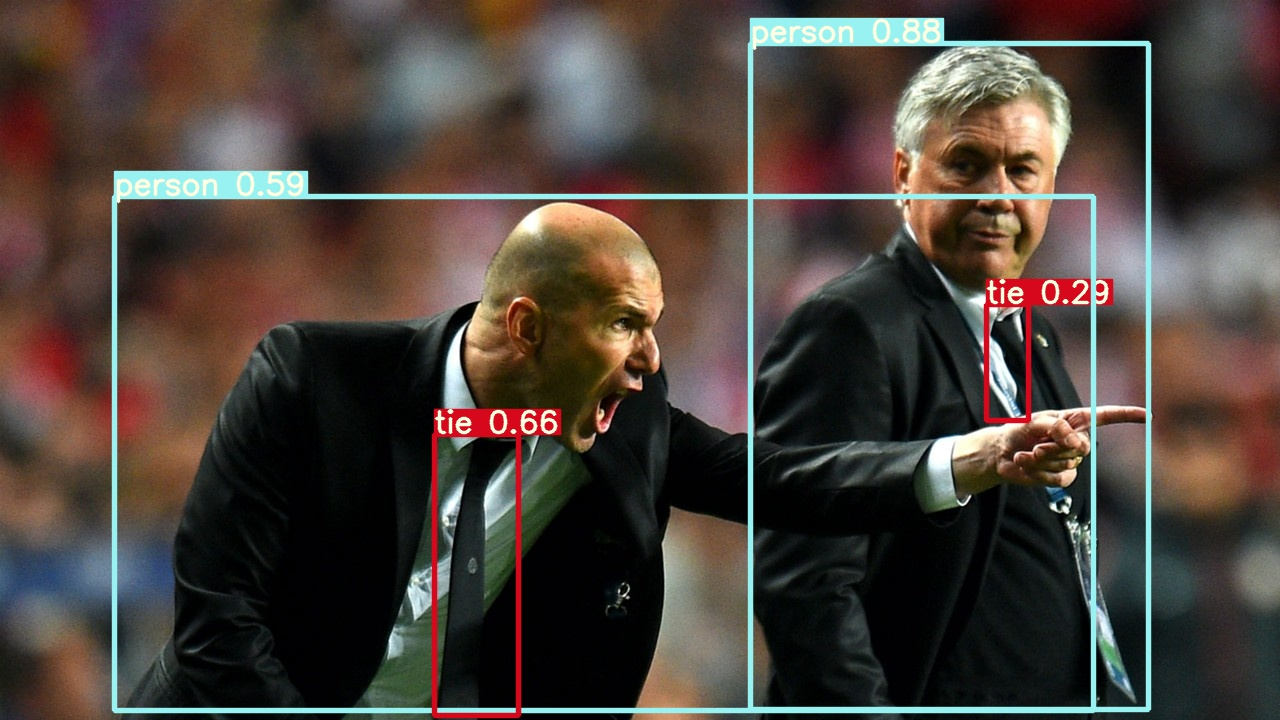

In [10]:
%cd /content/yolov5
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
#clear_output()

from IPython.display import Image as display_image
display_image(filename='runs/detect/exp/zidane.jpg', width=100)

In [11]:
%cd /content 
df = df_yolo.copy()
label_delta_threshold = 0.08
df = df[df["delta"] > label_delta_threshold].reset_index(drop=True)

X = df["ID"]
y = df["Year"]
df["fold"] = -1

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    df.loc[test_index, "fold"] = i    

print(df["ID"].unique().shape, df.shape)

df.to_csv("lacuna_yolo_5folds_full.csv", index=None)
df.head()

/content
(1077,) (1077, 15)


,ID,Year,PlotSize_acres,Yield,Quality,x,y,extra,r,delta,ratio,is_center,win,yolo,fold
0,id_ade6610c,2018,0.25,NaN,2,-0.100546,0.131002,0,0.179,0.165139,0.922566,0,"(0.716, 0.716)","[0.591, 0.591, 0.273, 0.273]",3
1,id_c987f14e,2018,2.00,NaN,1,-0.985732,-0.032197,0,0.508,0.986257,1.941452,0,"(2.032, 2.032)","[0.742, 0.5, 0.258, 0.258]",3
2,id_fe53ff60,2018,0.25,NaN,1,0.173911,0.273041,0,0.179,0.323723,1.808507,0,"(0.716, 0.716)","[0.364, 0.682, 0.273, 0.273]",3
3,id_b6963bf4,2018,0.25,NaN,1,-0.154585,0.264809,0,0.179,0.306627,1.713000,0,"(0.716, 0.716)","[0.591, 0.682, 0.273, 0.273]",2
4,id_e8b01d38,2018,0.50,NaN,3,-0.023581,0.115329,0,0.254,0.117715,0.463447,0,"(1.016, 1.016)","[0.5, 0.567, 0.267, 0.267]",3


In [12]:
%cd /content 
workspace_dir = "workspace"

LABEL_CODE = 0
periods = ["jun17", "dec17", "jun18", "dec18"]

data_dir = "./lacuna_images"

for fold in range(5):
    workspace_fold_dir = f"{workspace_dir}/fold_{fold}"
    workspace_train_dir = f"{workspace_dir}/fold_{fold}/train"
    workspace_val_dir = f"{workspace_dir}/fold_{fold}/val"

    !rm -rf $workspace_fold_dir
    !mkdir -p $workspace_train_dir
    !mkdir -p $workspace_val_dir

    for index, row in tqdm(df.iterrows()):
        new_dir = workspace_train_dir if row["fold"] != fold else workspace_val_dir

        ID = row["ID"]
        for period in periods:
            filename = f"{ID}_{period}.png"
            shutil.copy(f'{data_dir}/{filename}', f'{new_dir}/{filename}')
        
            txt_file = filename.replace(".png",".txt")
            txt_full_filename = f'{new_dir}/{txt_file}'
            with open(txt_full_filename, 'w') as file: 
                b = row["yolo"] # eval(row["yolo"]) # convert to list
                new_line = "{} {} {} {} {} \n".format(LABEL_CODE, b[0], b[1], b[2], b[3]) 
                file.write(new_line) 

    clear_output()

!ls workspace/fold_0/train/*.txt | wc
!ls workspace/fold_0/train/*.png | wc

!ls workspace/fold_4/val/*.txt | wc
!ls workspace/fold_4/val/*.png | wc

   3444    3444  154980
   3444    3444  154980
    860     860   36980
    860     860   36980


In [13]:
data = '''
train: /content/workspace/fold_{}/train/ 
val: /content/workspace/fold_{}/val/
nc: 1
names: ["lacuna"]
'''

for fold in range(5):
    text_data = data.format(fold, fold)
    text_file = open("workspace/lacuna_train_val_fold_{}.yaml".format(fold), 'w+')
    n = text_file.write(text_data)
    text_file.close()

!cat workspace/lacuna_train_val_fold_0.yaml
!echo ""
!cat workspace/lacuna_train_val_fold_4.yaml


train: /content/workspace/fold_0/train/ 
val: /content/workspace/fold_0/val/
nc: 1
names: ["lacuna"]


train: /content/workspace/fold_4/train/ 
val: /content/workspace/fold_4/val/
nc: 1
names: ["lacuna"]


In [14]:
%%writefile lacuna_hyp.yaml
# https://github.com/ultralytics/yolov5/blob/master/data/hyp.scratch.yaml
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials


lr0: 0.005 # 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1 # 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg) # ========== ADDED
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.5  # image flip up-down (probability) # ========== ADDED
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)

Writing lacuna_hyp.yaml


In [15]:
# !WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache 
%cd /content/yolov5

!rm -rf runs/train

!cp /content/workspace/*.yaml .
!cp /content/*.yaml .

for fold in range(5):
    print(f"Training fold {fold}")
    fold_yaml_file = f"lacuna_train_val_fold_{fold}.yaml"

    !WANDB_MODE="dryrun" python train.py --img 128 --batch 128 --epochs 80 \
        --hyp lacuna_hyp.yaml \
        --data $fold_yaml_file  \
        --weights yolov5s.pt 

print("DONE")

/content/yolov5
Training fold 0
github: up to date with https://github.com/tiendzung-le/yolov5 ✅
YOLOv5 🚀 v5.0-10-g585dd23 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=128, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='lacuna_train_val_fold_0.yaml', device='', entity=None, epochs=80, evolve=False, exist_ok=False, global_rank=-1, hyp='lacuna_hyp.yaml', image_weights=False, img_size=[128, 128], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=128, upload_dataset=False, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-06-24 11:44:02.265412: I tensorflow/stream_executor/platform/default/ds

In [16]:
%cd /content/
!ls /content/yolov5/runs/train/exp*/weights/best.pt

/content
/content/yolov5/runs/train/exp2/weights/best.pt
/content/yolov5/runs/train/exp3/weights/best.pt
/content/yolov5/runs/train/exp4/weights/best.pt
/content/yolov5/runs/train/exp5/weights/best.pt
/content/yolov5/runs/train/exp/weights/best.pt


# Inference

In [17]:
df_test = pd.read_csv("./lacuna-data/test.csv")
df_train = pd.read_csv("./lacuna-data/train-unique.csv")
df_train = df_train[list(df_test.columns)]
df_test["set"] = "test"
df_train["set"] = "train"
print(df_test.columns)
df_all = pd.concat([df_test, df_train]).reset_index(drop=True)
print(df_all["set"].value_counts())
df_all.head()

Index(['ID', 'Year', 'PlotSize_acres', 'Yield', 'set'], dtype='object')
test     1613
train     366
Name: set, dtype: int64


,ID,Year,PlotSize_acres,Yield,set
0,id_e7032b10,2016,0.50,0.0,test
1,id_ae7cb51e,2018,1.00,NaN,test
2,id_e59f7730,2018,1.00,NaN,test
3,id_b9011c86,2018,1.50,NaN,test
4,id_caaeb9f8,2018,0.25,NaN,test


In [18]:
def create_yolo_images_size(row, output_dir="lacuna_images"):
    ID = row["ID"] # row.ID.values[0]
    extra = 0 #row["extra"] # row.extra.values[0] == 1
    img_jun17, img_dec17, img_jun18, img_dec18 = load_RGB_images(ID, extra)


    x0, y0 = img_jun18.shape[1]//2, img_jun17.shape[0]//2
    r = np.round(row["r"] / CONST_X * img_jun17.shape[1])

    cx, cy = 0, 0
    (wx, wy) = row["win"]
    left,right = (cx-wx), (cx+wx)
    top,down = (cy-wy), (cy+wy)
    left = x0 - np.round(left / CONST_X * img_jun18.shape[1])
    right = x0 - np.round(right / CONST_X * img_jun18.shape[1])
    top = y0 + np.round(top / CONST_Y * img_jun18.shape[0])
    down = y0 + np.round(down / CONST_Y * img_jun18.shape[0])


    new_width = abs(int(right)-int(left))
    new_height = abs(int(top) - int(down))
    new_left = int(right) # inverted
    new_right = int(left)

    for img_full, period in zip([img_jun17, img_dec17, img_jun18, img_dec18], 
                                ["jun17", "dec17", "jun18", "dec18"]):
        im = img_full[int(top):int(down),new_left:new_right,:]
        im_fn = f"{output_dir}/{ID}_{period}.png"
        skimage.io.imsave(im_fn, im)
        
    return (img_jun18.shape, (top, down), (new_left, new_right))

%cd /content
output_dir="workspace/inference"
!mkdir -p $output_dir

df_all["r"] = df_all["PlotSize_acres"].map(get_radius)
df_all["win"] = df_all.apply(lambda r: get_win_info(r), axis=1)
df_all["image_cut"] = df_all.progress_apply(lambda r: create_yolo_images_size(r, output_dir), axis=1)

clear_output()
!ls $output_dir | wc

df_all.to_csv("df_all_inference_all.csv", index=None)
df_all.head()

   7916    7916  174152


,ID,Year,PlotSize_acres,Yield,set,r,win,image_cut
0,id_e7032b10,2016,0.50,0.0,test,0.254,"(1.016, 1.016)","((82, 83, 3), (26.0, 56.0), (26, 56))"
1,id_ae7cb51e,2018,1.00,NaN,test,0.359,"(1.436, 1.436)","((82, 84, 3), (20.0, 62.0), (20, 64))"
2,id_e59f7730,2018,1.00,NaN,test,0.359,"(1.436, 1.436)","((82, 84, 3), (20.0, 62.0), (20, 64))"
3,id_b9011c86,2018,1.50,NaN,test,0.440,"(1.76, 1.76)","((84, 84, 3), (15.0, 69.0), (15, 69))"
4,id_caaeb9f8,2018,0.25,NaN,test,0.179,"(0.716, 0.716)","((84, 84, 3), (31.0, 53.0), (31, 53))"


In [ ]:
%cd /content/yolov5
!rm -rf runs/detect/
full_val_dir = "/content/workspace/inference"

for fold in range(5):
    best_weights = "/content/yolov5/runs/train/exp/weights/best.pt"
    if fold > 0:
        best_weights = f"/content/yolov5/runs/train/exp{fold+1}/weights/best.pt"
    print(best_weights)

    !python mydetect.py --weights $best_weights --img 128 --conf 0.2 \
            --source $full_val_dir --save-txt --save-conf

    clear_output()
    
!ls runs/detect/exp*/output.txt

In [ ]:
%cd /content/
!ls -alh /content/yolov5/runs/detect/exp*/output.txt 

# Submission

In [21]:
%cd /content

df_all = pd.read_csv("df_all_inference_all.csv")
df_all.head()

df_folds = pd.read_csv("lacuna_yolo_5folds_full.csv")
df_folds.head()

df_val = pd.merge(df_all[["ID", "Year", "PlotSize_acres", "image_cut", "set"]],
              df_folds[["ID", "x", "y", "delta", "fold"]], on="ID", how="left")

df_val["image_cut"] = df_val["image_cut"].apply(lambda x: eval(x))
    
df_val["fold"] = df_val["fold"].fillna(-1).astype(int)
print(df_val.shape)
df_val.tail()

/content
(1979, 9)


,ID,Year,PlotSize_acres,image_cut,set,x,y,delta,fold
1974,id_387fcf14,2015,1.00,"((84, 84, 3), (20.0, 64.0), (20, 64))",train,0.169148,0.101470,0.197249,4
1975,id_34b4d068,2015,0.40,"((84, 84, 3), (28.0, 56.0), (28, 56))",train,-0.087902,-0.027066,0.091975,3
1976,id_7940ea69,2015,0.50,"((84, 83, 3), (26.0, 58.0), (26, 56))",train,-0.289853,0.108825,0.309609,2
1977,id_1a45efa2,2015,0.75,"((83, 84, 3), (22.0, 60.0), (23, 61))",train,-0.629659,0.127603,0.642458,1
1978,id_3df95f62,2015,1.00,"((84, 83, 3), (20.0, 64.0), (19, 63))",train,-0.182798,-0.191495,0.264737,4


In [ ]:
import itertools
import statistics
import math

CONST_X = 10.986328125 / 2
CONST_Y = 10.985731758 / 2

# Decide if detected boxes are consistent or not
# 3, 4, 5 elements
# 3 elements form a median center (+- 0.04)

yolo_threshold_center_to_point = 0.05 # 0.04  => LB 0.2205, 0.045 => LB 0.2203
confident_ratio = 1 # 1 ==> Full, 0.5: safety

print("yolo_threshold_center_to_point:", yolo_threshold_center_to_point)
print("confident_ratio:", confident_ratio)

def get_x_y_pred(row, confident_ratio=1):
    center = row["center"]
    image_cut = row["image_cut"] # eval(row["image_cut"])
    
    # (img_jun18.shape, (top, down), (new_left, new_right))
    x1 = center[0] - 0.5
    x1 = x1 * (image_cut[2][1] - image_cut[2][0])
    
    y1 = center[1] - 0.5
    y1 = y1 * (image_cut[1][1] - image_cut[1][0])
    
    # left = x0 - np.round(left / CONST_X * img_jun18.shape[1])
    x1 = (- x1 / image_cut[0][1]) * CONST_X
    y1 = (y1 / image_cut[0][0]) * CONST_X

    return round(x1*confident_ratio,6), round(y1*confident_ratio,6)
    
def get_delta(r):
    xx = r["x"]
    yy = r["y"]
    return math.sqrt(xx*xx + yy*yy)

def get_delta_pred(r):
    xx = r["x"]
    yy = r["y"]
    x1 = r["x_pred"]
    y1 = r["y_pred"]    
    return math.sqrt((x1-xx)*(x1-xx) + (y1-yy)*(y1-yy))

def get_center(elements):
    center = (0.5, 0.5)
    
    if str(elements) == "nan":
        return center
    
    if len(elements) >= 6:
        return center
    if len(elements) <= 2:
        return center
    
    min_distance= 1000
    
    for comb in itertools.combinations(elements, 3):
        cx = statistics.median([e[0] for e in comb])
        cy = statistics.median([e[1] for e in comb])
        
        good_center = True
        for e in comb:
            if abs(cx-e[0]) > yolo_threshold_center_to_point:
                good_center = False
            if abs(cy-e[1]) > yolo_threshold_center_to_point:
                good_center = False 
        
        if good_center:
            #print(comb)
            distance = sum([abs(cx-e[0]) for e in comb]) + sum([abs(cy-e[0]) for e in comb])
            
            if distance < min_distance:
                center = (cx, cy)
                min_distance = distance
    return center

df_avgs = []
scores = []
for fold in range(5):
    output_file = f"yolov5/runs/detect/exp/output.txt"
    if fold > 0:
        output_file = f"yolov5/runs/detect/exp{fold+1}/output.txt"
    print(output_file)

    df_output = pd.read_csv(output_file, header=None)
    df_output.columns = ["filename", "yolo"]
    df_output["ID"] = df_output["filename"].apply(lambda x: x.split("/")[-1][:-6])
    df_output["period"] = df_output["filename"].apply(lambda x: x.split("/")[-1][-5:])
    df_output["cc"] = df_output["yolo"].apply(lambda x: [float(e) for e in x.split(" ")[1:3]])

    if "filename" in df_output.columns:
        del df_output["filename"]

    df_cc = df_output.groupby("ID")["cc"].apply(list).to_frame("cc").reset_index()
    df_cc = pd.merge(df_cc, df_val[["ID", "x", "y", "Year", "image_cut", "fold"]], on="ID", how="left")
    df_cc["center"] = df_cc["cc"].map(lambda elements: get_center(elements))


    df_cc["x_pred"], df_cc["y_pred"] = zip(*df_cc.apply(lambda r: get_x_y_pred(r, confident_ratio), axis=1))
    df_cc["delta"] = df_cc.apply(lambda r: get_delta(r), axis=1)
    df_cc["delta_pred"] = df_cc.apply(lambda r: get_delta_pred(r), axis=1)

    print(f"fold {fold}:", df_cc["delta"].mean(), df_cc["delta_pred"].mean())
    scores.append((fold, df_cc["delta"].mean(), df_cc["delta_pred"].mean()))
    
    df_avgs.append(df_cc[["ID", "x_pred", "y_pred"]])

print(len(df_avgs))
df_cc[df_cc["fold"] >= 0].sample(n=5)

In [23]:
benchmark_score = sum([s[1] for s in scores]) / len(scores) # delta_pred - delta
print("benchmark_score:", benchmark_score)

train_score = sum([s[2] for s in scores]) / len(scores) # delta_pred - delta
print("train_score:", train_score)

text_file = open("scores.txt", 'w+')
text_file.write(f"benchmark_score: {benchmark_score}\n")
text_file.write(f"train_score: {train_score}\n")
text_file.close()

!cat scores.txt

benchmark_score: 0.36830702849965075
train_score: 0.34852880898217026
benchmark_score: 0.36830702849965075
train_score: 0.34852880898217026


In [24]:
df_avg = None
for fold, df_pred in enumerate(df_avgs):
    df_tmp = df_pred.rename(columns={"x_pred": f"x_{fold}", "y_pred": f"y_{fold}"})
    if df_avg is None:
        df_avg = df_tmp
    else:
        df_avg = pd.merge(df_avg, df_tmp, on="ID", how="outer")
print(df_avg.shape)
df_avg = df_avg.fillna(0)

operation = "mean"
if operation == "median":
    df_avg["x_pred"] = df_avg[[f"x_{fold}" for fold in range(5)]].median(axis=1) # mean
    df_avg["y_pred"] = df_avg[[f"y_{fold}" for fold in range(5)]].median(axis=1) # mean
else:
    df_avg["x_pred"] = df_avg[[f"x_{fold}" for fold in range(5)]].mean(axis=1) # mean
    df_avg["y_pred"] = df_avg[[f"y_{fold}" for fold in range(5)]].mean(axis=1) # mean
df_avg.sample(10)

(1840, 11)


,ID,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_pred,y_pred
822,id_7ff8a62b,-0.000000,0.000000,-0.000000,0.000000,0.130790,0.098092,-0.000000,0.000000,0.065395,0.163487,0.039237,0.052316
1145,id_b0cb4ee8,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
848,id_838e75d2,-0.261579,-0.425066,0.065395,0.098092,-0.000000,0.000000,-0.196184,-0.359671,-0.163487,-0.392369,-0.111171,-0.215803
1102,id_a9a0f2ca,-0.000000,0.000000,-0.000000,0.000000,-0.261579,-0.065395,0.000000,0.000000,0.000000,0.000000,-0.052316,-0.013079
1747,id_c91a05d0,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1052,id_a280bd3b,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
187,id_1c887d1d,0.523158,-0.228881,-0.000000,0.000000,0.523158,-0.130791,-0.000000,0.000000,0.523158,-0.098093,0.313895,-0.091553
1674,id_2af47256,0.000000,0.000000,0.066182,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.013236,0.000000
1551,id_f2c9d4df,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
1146,id_b12419a8,-0.066183,-0.132365,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.013237,-0.026473


In [25]:
#df_sub = pd.read_csv("./lacuna-data/sample_submission.csv")
df_sub = pd.read_csv("lacuna-data/sample_submission.csv")
print(df_sub.shape)
df_sub = pd.merge(df_sub, df_avg[["ID", "x_pred", "y_pred"]], on="ID", how="left").fillna(0)
df_sub.head(3)

df_sub["x"] = df_sub["x_pred"]
df_sub["y"] = df_sub["y_pred"]
sub_name = f"sub_ens_{operation}_{yolo_threshold_center_to_point}_{confident_ratio}.csv"
print(sub_name)
df_sub[["ID", "x", "y"]].to_csv(sub_name, index=None)

(1613, 3)
sub_ens_mean_0.05_1.csv


# Save

In [26]:
df_sub[["ID", "x", "y"]].to_csv(sub_name, index=None)
df_sub.head()

,ID,x,y,x_pred,y_pred
0,id_e7032b10,0.059564,0.073689,0.059564,0.073689
1,id_ae7cb51e,0.000000,0.000000,0.000000,0.000000
2,id_e59f7730,0.000000,0.000000,0.000000,0.000000
3,id_b9011c86,0.000000,0.000000,0.000000,0.000000
4,id_caaeb9f8,0.000000,0.000000,0.000000,0.000000
